# Update
* 1位の特徴量のみにすると、1.0457まで改善した。
# 

# 作業場

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_profiling import ProfileReport
import warnings
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib_venn import venn2
import lightgbm as lgbm
from contextlib import contextmanager
from time import time
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.model_selection import StratifiedKFold

# 1. データのロード

In [2]:
sns.set_style('darkgrid')
INPUT_DIR  = './../inputs'
OUTPUT_DIR = './../outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
#train_df = train_df.head(100)
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
#test_df = test_df.head(100)
pub = train_df['Publisher']

# 2.特徴量エンジニアリング

In [3]:
def make_features(train_df,df):
    gy_rank = df.sort_values(['Genre', 'Year_of_Release']).groupby(['Genre', 'Year_of_Release']).cumcount()
    gy_cnt = df.sort_values(['Genre', 'Year_of_Release']).groupby(['Genre', 'Year_of_Release'])['Name'].transform('count')
    df['Name_serial_num_per'] = (gy_rank / gy_cnt).sort_index()
    ny_rank = df.sort_values(['Name', 'Year_of_Release']).groupby(['Name', 'Year_of_Release']).cumcount()
    ny_cnt = df.sort_values(['Name', 'Year_of_Release']).groupby(['Name', 'Year_of_Release'])['Genre'].transform('count')
    df['Genre_serial_num_per'] = (ny_rank / ny_cnt).sort_index()
    df['Name_serial_num_per'] = df['Name_serial_num_per'].fillna(0)
    df['Genre_serial_num_per'] = df['Genre_serial_num_per'].fillna(0)

    #Name
    #mario_df = []
    #     #tetris_df = []
    lego_df = []
    for i in range(len(df)):
        a = pd.DataFrame(df['Name'].astype(str))
        #mario_df.append('mario' in a.Name.str.lower().values[i])
        lego_df.append('lego' in a.Name.str.lower().values[i])
    #df['mario'] = mario_df
    df['lego'] = lego_df 
    
    # Year_of_releasea
    df[df['Year_of_Release']=='Role-Playing'] = 0
    df[df['Year_of_Release']=='Adventure']  = 0
    tdf_year =df['Year_of_Release'].fillna(0)
    df['Year_of_Release'] = tdf_year
    #vc = df.groupby('Year_of_Release')['Year_of_Release'].count()
    #df['Year_of_Release'] = df['Year_of_Release'].map(vc)
                       
    #Platform, Genre
    df_ = df['Genre']
    train_df['Sales'] =train_df['NA_Sales']+train_df['EU_Sales']+train_df['JP_Sales']+train_df['Other_Sales']
    tra_vc = train_df.groupby('Genre')['Sales'].sum()
    pf_vc = df['Platform'].value_counts()
    gr_vc = df['Genre'].value_counts()
    df['Platform'] = df['Platform'].map(pf_vc)
    df['Genre_weight'] = df['Genre'].map(tra_vc)
    df['Genre'] = df['Genre'].map(gr_vc)
    
    #Publisher
    
    # Critic_Score, Critic_Count,User_Score,User_Count
    df[df['User_Score']=='tbd'] =0
    df['User_Score'] = df['User_Score'].fillna(df['User_Score'].median())
    df['Critic_Score'] = df['Critic_Score'].fillna(df['Critic_Score'].median())
    df['Critic_Count'] = df['Critic_Count'].fillna(df['Critic_Count'].median())    
    df['User_Count'] = df['User_Count'].fillna(df['User_Count'].median()) 
    
    # Developer
    df[df['Developer']==None] ='other'
    df['Developer'] = df['Developer'].fillna(0)
    d_vc = df['Developer'].value_counts()
    d_vc_ =d_vc[d_vc<50].index
    for i in range(len(d_vc_)):
        df.loc[df['Developer']==d_vc_[i],'Developer'] = 'other'
    df['Developer'] = df['Developer'].map(d_vc)                       
    
    # Rating
    df[df['Rating']==None] = 'other'     
    df['Rating'] = df['Rating'].fillna(0)
    r_vc = df['Rating'].value_counts()

    df['Rating'] = df['Rating'].map(r_vc)
    try:
        drop_list = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Sales','Publisher','Platform']#,'Rating','Platform','Year_of_Release','Developer','Genre_serial_num_per','User_Score','User_Count']
        df = df.drop(drop_list,axis=1)
    except:
        drop_list = ['Publisher','Platform']#,'Rating','Platform','Year_of_Release','Developer','Genre_serial_num_per','User_Score','User_Count']
        df = df.drop(drop_list,axis=1)
    return df

In [4]:
test_df  = make_features(train_df,test_df)
train_df = make_features(train_df,train_df)

C:\Users\ur089\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# 変数設定

In [5]:
sc = StandardScaler()
lim_X = train_df.drop('Global_Sales',axis=1)
lim_X = lim_X.iloc[:,1:]
lim_y = train_df['Global_Sales']
lim_y.fillna(0)
lim_y = pd.DataFrame(lim_y)

In [6]:
lim_X.columns

Index(['Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Developer', 'Rating',
       'Name_serial_num_per', 'Genre_serial_num_per', 'lego', 'Genre_weight'],
      dtype='object')

# Atmaおかり

In [7]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""
    metric_func = mean_squared_error
    
    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    # float にしないと悲しい事件が起こるのでそこだけ注意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]
        clf = lgbm.LGBMRegressor(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {metric_func(y_valid, pred_i) ** .5:.4f}')

    score = metric_func(y, oof_pred) ** .5
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [8]:
params = {
    'objective': 'rmse', # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'learning_rate': .1, # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'max_depth': 5, # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'n_estimators': 10000, # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'colsample_bytree': .5, # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'importance_type': 'gain' # 特徴重要度計算のロジック(後述)
}

y = lim_y['Global_Sales'].values
y = np.log1p(y.astype(np.float64))
#y = np.log1p(y) # log + plus1 変換する　>>「RMSLE を最適化する小技RMSLE を最適化する小技」RMSEの話のところ

In [9]:
from sklearn.model_selection import KFold, GroupKFold
fold = KFold(n_splits=10, shuffle=True, random_state=71)
cv = list(fold.split(lim_X, y)) # もともとが generator なため明示的に list に変換する

In [10]:
oof, models = fit_lgbm(lim_X.values, y, cv, params=params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.404973
[100]	valid_0's rmse: 0.379128
[150]	valid_0's rmse: 0.370853
[200]	valid_0's rmse: 0.370148
Early stopping, best iteration is:
[181]	valid_0's rmse: 0.369255
fit fold=1 0.200[s]
Fold 0 RMSLE: 0.3693
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.456339
[100]	valid_0's rmse: 0.433267
[150]	valid_0's rmse: 0.428164
[200]	valid_0's rmse: 0.426722
[250]	valid_0's rmse: 0.423527
[300]	valid_0's rmse: 0.422467
[350]	valid_0's rmse: 0.420886
Early stopping, best iteration is:
[342]	valid_0's rmse: 0.420426
fit fold=2 0.259[s]
Fold 1 RMSLE: 0.4204
[LightGBM] [Warning] Accuracy may be bad since you didn't explici

In [11]:
def split_by_groups(groups):
    kfold = KFold(n_splits=10, random_state=71, shuffle=True)
    groups = pd.Series(groups)
    unique_groups = groups.unique()
    splits = []
    
    def _filter_ids(idx):
        values = unique_groups[idx]
        idx = groups.isin(values)
        return groups[idx].index.values
    
    for idx_tr, idx_val in kfold.split(unique_groups):
        splits.append([
            _filter_ids(idx_tr), _filter_ids(idx_val)
        ])
        
    return splits

In [12]:
#pub = train_df['Publisher']
cv = split_by_groups(pub)
oof, models = fit_lgbm(lim_X.values, y, cv, params=params)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.356231
[100]	valid_0's rmse: 0.340897
[150]	valid_0's rmse: 0.333346
[200]	valid_0's rmse: 0.330413
[250]	valid_0's rmse: 0.329135
[300]	valid_0's rmse: 0.325748
[350]	valid_0's rmse: 0.323317
[400]	valid_0's rmse: 0.320617
[450]	valid_0's rmse: 0.320279
Early stopping, best iteration is:
[433]	valid_0's rmse: 0.319487
fit fold=1 0.301[s]
Fold 0 RMSLE: 0.3195
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.424166
[100]	valid_0's rmse: 0.41253
[150]	valid_0's rmse: 0.406902
[200]	valid_0's rmse: 0.400428
[250]	valid_0's rmse: 0.395086
[300]	valid_0's rmse: 0.393635
[350]	valid_0's rmse: 0.391241
[400]	valid_0's rm

In [13]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

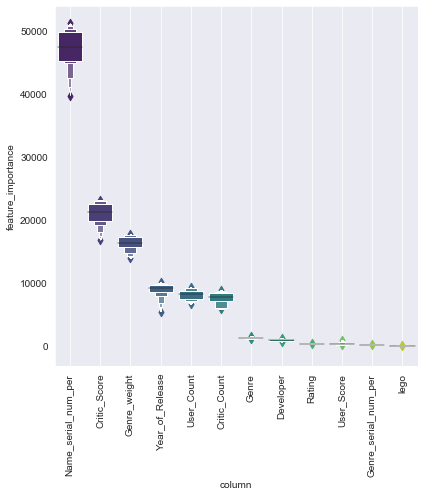

In [14]:
fig, ax = visualize_importance(models, lim_X)

In [15]:
#lim_X_['mario'] = mario_df
lim_X_ = test_df.iloc[:,1:]
display(lim_X_)
print(lim_X_.values)

,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Name_serial_num_per,Genre_serial_num_per,lego,Genre_weight
0,0,1627,84,23,8,19,NaN,770,0,0,False,106268
1,0,1627,91,17,9,132,NaN,1357,0,0,False,106268
2,0,1627,87,28,8.5,39,NaN,770,0,0,False,106268
3,0,1627,70,54,6.9,180,NaN,770,0,0,False,106268
4,0,1627,71,41,6.9,143,NaN,770,0,0,False,106268
...,...,...,...,...,...,...,...,...,...,...,...,...
8355,2016,293,65,15,6.7,13,4410,4472,0,0,False,9179
8356,2016,293,65,15,6.7,13,4410,4472,0.25,0.5,False,9179
8357,2016,293,71,15,7.1,71,NaN,4472,0.5,0,False,9179
8358,2016,293,65,15,6.7,13,4410,4472,0.75,0,False,9179


[[0 1627.0 84 ... 0.0 False 106268.0]
 [0 1627.0 91 ... 0.0 False 106268.0]
 [0 1627.0 87 ... 0.0 False 106268.0]
 ...
 [2016 293.0 71 ... 0.0 False 9179.0]
 [2016 293.0 65 ... 0.0 False 9179.0]
 [0 0.0 0 ... 0.0 0 0.0]]


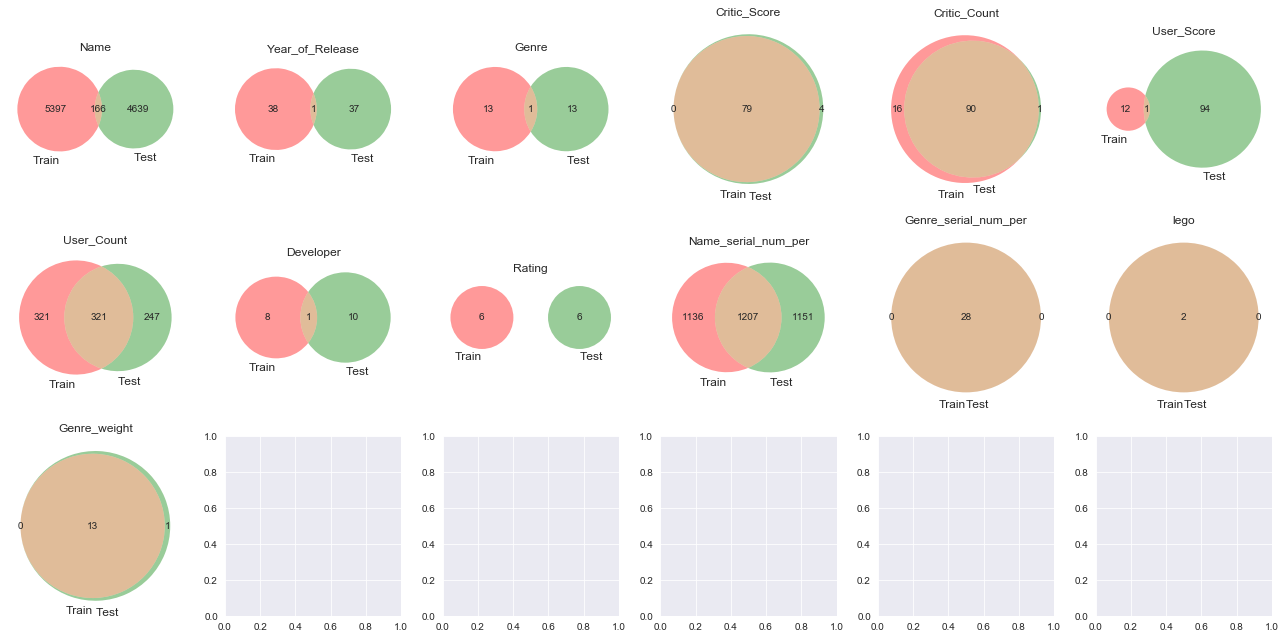

In [16]:
# trainには存在するデータ項目がtestデータには存在しない項目があるので、testデータにcolumnsを合わせる。
columns = test_df.columns
#　graphの数
n_figs = len(columns)
# 横に並べるgraphの数
n_cols = 6
# 縦に並べるgraphの数
n_rows = n_figs // n_cols + 1
# graph配置指定
fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), ncols=n_cols, nrows=n_rows)
# ven図のプロットfor文                         
for c, ax in zip(columns, axes.ravel()):
    venn2(
        subsets=(set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels=('Train', 'Test'),
        ax=ax
    )
    ax.set_title(c)
fig.tight_layout()

In [17]:
pred = np.array([model.predict(lim_X_.values) for model in models])
pred = np.mean(pred, axis=0)
pred = np.expm1(pred)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, '041_mysubmission.csv'), index=False)

In [18]:
print(lim_X.columns)
lim_X_.columns

Index(['Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Developer', 'Rating',
       'Name_serial_num_per', 'Genre_serial_num_per', 'lego', 'Genre_weight'],
      dtype='object')


Index(['Year_of_Release', 'Genre', 'Critic_Score', 'Critic_Count',
       'User_Score', 'User_Count', 'Developer', 'Rating',
       'Name_serial_num_per', 'Genre_serial_num_per', 'lego', 'Genre_weight'],
      dtype='object')